In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import json
import ast
from matplotlib.ticker import FuncFormatter
import glob
from matplotlib import animation
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import scipy
from scipy.stats import entropy
from sklearn import manifold
from adjustText import adjust_text
from mpl_toolkits import mplot3d
import networkx as nx
import os.path as osp
from sklearn import tree
import graphviz
from sklearn.metrics import classification_report
from itertools import product


In [2]:
#plt.style.use('seaborn-white')
plt.style.use('seaborn')
# for matplotlib xkcd I need to install new font without root, like this: 
#https://community.linuxmint.com/tutorial/view/29
# and then ivalidate cache like this: 
#https://stackoverflow.com/questions/19663986/getting-xkcd-plots-using-matplotlib/22812176#22812176
# or by deleting by: rm ~/.cache/matplotlib -r
# the font ttf file must be in ~/.fonts/fonts/truetype/humor-sans directory

# to recover from xkcd
#mpl.rcParams.update(saved_state)

# to save state and go to xkcd
#saved_state = mpl.rcParams.copy()
#plt.xkcd()
conf = {
    'font.size': 14.0,
    'axes.grid': True,
    'figure.titlesize': 'x-large',
    'axes.titlesize': 'x-large',
    'axes.labelsize': 'large',
#    'xtick.labelsize': 'medium',
#    'ytick.labelsize': 'medium',
#    'legend.fontsize': 'medium',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    'legend.fontsize': 'large',
}

plt.rcParams.update(conf)


In [3]:
# cleaned data are good for user anylysis but not for anime analysis. For users, around 200k animelist records were discarded, over 30m records remainded.
from pandas.io.common import _NA_VALUES
na_values = _NA_VALUES - {'NULL', 'null', 'nan', 'NaN'}

animes = pd.read_csv('anime_cleaned.csv')
users = pd.read_csv('users_cleaned.csv', na_values=na_values, keep_default_na=False)
animelists = pd.read_csv('animelists_cleaned.csv', na_values=na_values, keep_default_na=False)

In [4]:
users['birth_date'] = pd.to_datetime(users['birth_date'])
users['last_online'] = pd.to_datetime(users['last_online'])
users['join_date'] = pd.to_datetime(users['join_date'])
animelists['my_last_updated'] = pd.to_datetime(animelists['my_last_updated'])
# renaming possibly array-like columns to end with -s
animes = animes.rename(columns={'genre': 'genres', 'studio': 'studios'})

In [5]:
# setting index for primary identifiers
animes = animes.set_index('anime_id')
users = users.set_index('username')


In [6]:
users['age'] = 2018 - users['birth_date'].dt.year   # fix this to be more robust and precise

In [7]:
animes.head()

,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,...,broadcast,related,producer,licensor,studios,genres,opening_theme,ending_theme,duration_min,aired_from_year
anime_id,,,,,,,,,,,,,,,,,,,,,
11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,False,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,False,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,False,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,False,...,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0


In [8]:
animelists.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN


In [9]:
users.head()

,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,age
username,,,,,,,,,,,,,,,,,
karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391,28
Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,2017-07-10 06:52:54,6.15,6.0,4903,27
bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,9701,28
terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,697,20
Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24,NaN,2015-11-26,2018-05-10 20:53:37,7.86,0.0,1847,19


### comparison of all and active users
Active users are users with some ratings in last 3 months

In [10]:
# newest update date, reflects time of data gathering
now = animelists['my_last_updated'].max()
now

Timestamp('2018-05-22 07:49:06')

In [11]:
from dateutil.relativedelta import relativedelta
last_update = animelists.groupby('username')['my_last_updated'].max()
is_active = last_update > (now - relativedelta(months=3))
active_users = last_update[is_active].index

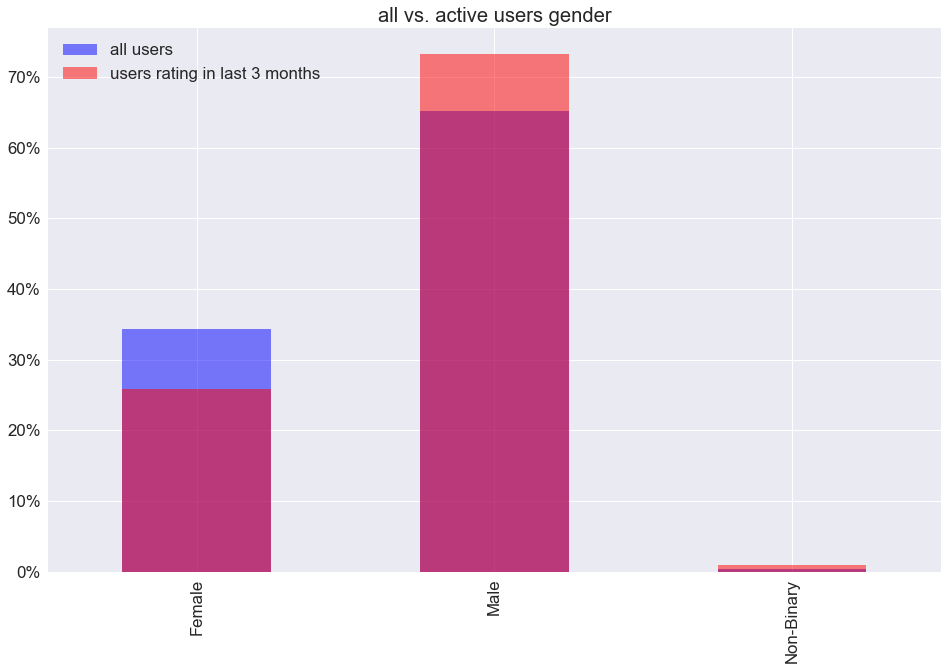

In [12]:
(users['gender'].value_counts() / users['gender'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users gender', color='blue', alpha=0.5, label='all users')
(users.loc[active_users]['gender'].value_counts() / users.loc[active_users]['gender'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)

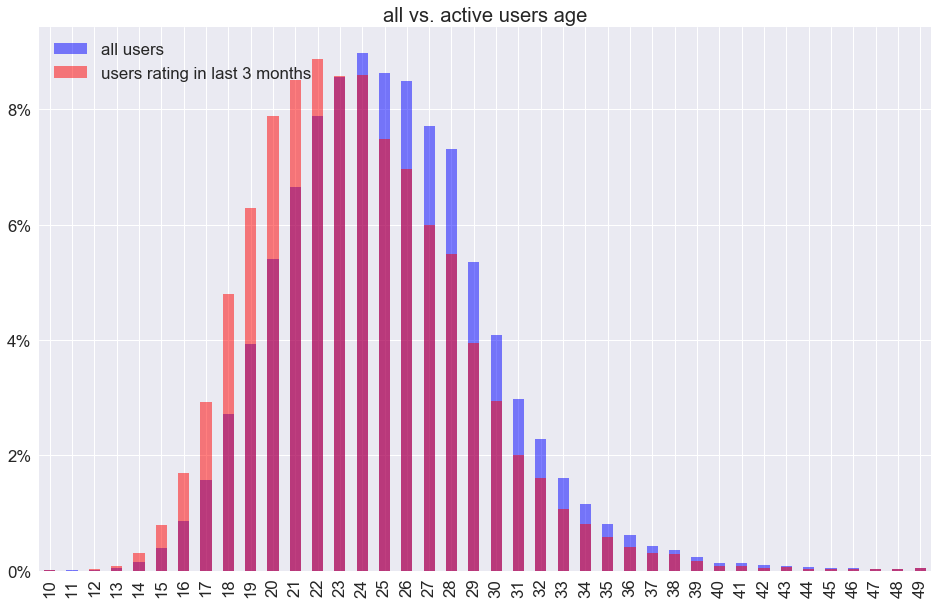

In [13]:
(users['age'].value_counts() / users['age'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users age', color='blue', alpha=0.5, label='all users')
(users.loc[active_users]['age'].value_counts() / users.loc[active_users]['age'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)

### inspecing seen animes per all genres by age, gender etc.

In [14]:
animes['genres'].fillna('', inplace=True)
genres_arr = animes['genres'].str.replace(' ', '').str.split(',', expand=True).stack().reset_index(drop=True, level=1).to_frame(name='genre')
genres_arr = genres_arr[genres_arr['genre'] != '']
animes_genres = pd.merge(animes, genres_arr, how='inner', left_index=True, right_index=True)
genres = genres_arr['genre'].unique()

In [15]:
# the fastest and safest option (having separate dataframe per each genre is better than one big dataframe)
from joblib import Parallel, delayed
# todo: rewrite all queries using animelists_genres to access dict
def filter_by_genre(animelists, genre):
    print(genre)
    return genre, animelists[animelists.index.isin(genres_arr[genres_arr['genre'] == genre].index)]

res_lists = Parallel(n_jobs=16, backend='threading')(delayed(filter_by_genre)(animelists, genre) for genre in genres_arr['genre'].unique())
animelists_genres = {key: val for key, val in res_lists}

ComedySupernaturalRomance
ShounenParody


School
Magic
Shoujo
Drama
Fantasy
Kids
Action
MusicSliceofLife
JoseiHarem



ShounenAi
Adventure
SuperPower
Sci-Fi
Ecchi
Seinen
MartialArtsGame

Sports
Demons
HistoricalHorror
Mystery

Psychological
Vampire
MechaMilitary

Space
Samurai
Thriller
Hentai
Yaoi
ShoujoAi
Police
CarsDementiaYuri




In [18]:
# semantics of my_status column
status = {
    'watching': 1,
    'completed': 2,
    'on hold': 3,
    'dropped': 4,
    'plan to watch': 6,
}

In [19]:
if osp.exists('users_calculated.csv'):
    users = pd.read_csv('users_calculated.csv')
    users = users.set_index('username')
else:
    # handcrafted features
    genres_columns = ['completed_'+x for x in genres]
    for genre_column, genre in zip(genres_columns, genres):
        animelists_genre = animelists_genres[genre]
        completed = animelists_genre['my_status'] == status['completed']
        users[genre_column] = animelists_genre[completed].groupby('username')['anime_id'].count()
    
    genres_columns = ['dropped_'+x for x in genres]
    for genre_column, genre in zip(genres_columns, genres):
        animelists_genre = animelists_genres[genre]
        dropped = animelists_genre['my_status'] == status['dropped']
        users[genre_column] = animelists_genre[dropped].groupby('username')['anime_id'].count()
    
    genres_columns = ['meanscore_'+x for x in genres]
    for genre_column, genre in zip(genres_columns, genres):
        animelists_genre = animelists_genres[genre]
        rated = (animelists_genre['my_score'] != 0)
        completed = animelists_genre['my_status'] == status['completed']
        users[genre_column] = animelists_genre[completed & rated].groupby('username')['my_score'].mean()

    # good score is 9 or higher
    genres_columns = ['scoreabove8_'+x for x in genres]
    for genre_column, genre in zip(genres_columns, genres):
        animelists_genre = animelists_genres[genre]
        completed = animelists_genres['my_status'] == status['completed']
        rated = animelists_genres['my_score'] > 8
        users[genre_column] = animelists_genre[completed & rated].groupby('username')['my_score'].count()

    # score is 10
    genres_columns = ['scoreabove9_'+x for x in genres]
    for genre_column, genre in zip(genres_columns, genres):
        animelists_genre = animelists_genres[genre]
        completed = animelists_genres['my_status'] == status['completed']
        rated = animelists_genres['my_score'] > 9
        users[genre_column] = animelists_genre[completed & rated].groupby('username')['my_score'].count()
    
    completed = (animelists['my_status'] == status['completed'])
    dropped = (animelists['my_status'] == status['dropped'])
    rated = (animelists['my_score'] != 0)
    users['all_completed'] = animelists[completed].groupby('username')['anime_id'].count()
    users['all_dropped'] = animelists[dropped].groupby('username')['anime_id'].count()
    users['all_meanscore'] = animelists[completed & rated].groupby('username')['my_score'].mean()
    users['all_rated'] = animelists[completed & rated].groupby('username')['anime_id'].count()

    users.reset_index().to_csv('users_calculated.csv', index=False, sep=',', encoding='utf-8')

KeyError: 'Column not found: genre'

In [ ]:
#showing score distribution
scores = animelists[animelists['my_score'] != 0]['my_score'].value_counts()
(scores / scores.sum()).sort_index().plot(kind='bar', figsize=(16, 10), title='Rozdělení hodnocení')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xticks(rotation=0)
plt.savefig('graphs/uzivatele-hodnoceni.png', bbox_inches="tight")

In [ ]:
users['all_meanscore'].plot(kind='hist', bins=100, figsize=(16, 10), title='Rozdělení průměru hodnocení podle uživatelů')
plt.xticks(rotation=0)
plt.savefig('graphs/uzivatele-hodnoceni-prumer-histogram.png', bbox_inches="tight")

In [ ]:
print('total users:', users['all_meanscore'].count())
print('users with mean score 10:', (users['all_meanscore'] == 10).sum())


### analyzing users and genres now when I have features for genres per user

In [ ]:
completed_columns = sorted(['completed_'+x for x in genres])
completed_columns.remove('completed_')  # removed empty genre
users[completed_columns] = users[completed_columns].fillna(0)  # without this, NaN values are ommited from mean calculation, which messes up data a lot
# semantically, NaN is zero, because it means that user has no completed anime of that genre
users_completed = users[completed_columns].div(users['all_completed'], axis=0).fillna(0)
users_ages_completed = users_completed.join(users['age'])
ages_genres = users_ages_completed.groupby('age').mean()
users_genders_completed = users_completed.join(users['gender'])
genders_genres = users_genders_completed.groupby('gender').mean()

above8_columns = sorted(['scoreabove8_'+x for x in genres])
above8_columns.remove('scoreabove8_')  # removed empty genre
above9_columns = sorted(['scoreabove9_'+x for x in genres])
above9_columns.remove('scoreabove9_')  # removed empty genre
users[above8_columns] = users[above8_columns].fillna(0)
users[above9_columns] = users[above9_columns].fillna(0)
mean_columns = sorted(['meanscore_'+x for x in genres])
mean_columns.remove('meanscore_')  # removed empty genre
users[mean_columns] = users[mean_columns].fillna(0)


In [ ]:
# now try the histogram equalization on colormap to better show data
# histogram equalization taken from https://github.com/jobar8/graphics/blob/master/graphics.py and modified little bit
from skimage import exposure

def cmap_to_array(cmap,N=256):
    """
    Return a Nx3 array of RGB values generated from a colormap.
    """
    return cmap(np.linspace(0, 1, N))[:,:3] # remove alpha column

def equalize_colormap(cmap, data, name='EqualizedMap'):
    if type(data) is pd.DataFrame:
        data = data.as_matrix()
    data = data[~np.isnan(data)].flatten()
    cdf, bins = exposure.cumulative_distribution(data, nbins=256)
    # Using it for highly non-uniform data will cause high information loss for extreme values
    #So we do only half equalization, equalizing with histogram averaged with uniform histogram
    # and now the same for uniform distribution of same size
    cdf_u, bins_u = exposure.cumulative_distribution(np.linspace(data.min(), data.max(), data.shape[0]),nbins=256)
    cdf = (cdf + cdf_u) / 2
    '''
    Re-map a colormap according to a cumulative distribution. This is used to 
    perform histogram equalization of an image by changing the colormap 
    instead of the image. *This is not strickly speaking the equalization of the 
    colormap itself*.
    The cdf and bins should be calculated from an input image, as if carrying out
    the histogram equalization of that image. In effect, the cdf becomes integrated  
    to the colormap as a mapping function by redistributing the indices of the
    input colormap.
    
    Parameters
    ----------
    cmap : string or colormap object
        Input colormap to remap.
    bins : array
        Centers of bins.
    cdf : array
        Values of cumulative distribution function.
    '''
    
    # first retrieve the color table (lists of RGB values) behind the input colormap
    if cmap in mpl.cm.cmap_d: # matplotlib colormaps + plus the new ones (viridis, inferno, etc.)
        cmList = cmap_to_array(cm.cmap_d[cmap])
    else:
        try:
            # in case cmap is a colormap object
            cmList = cmap_to_array(cmap) 
        except:
            raise ValueError('Colormap {} has not been recognised'.format(cmap))
    
    # normalize the input bins to interval (0,1)
    bins_norm = (bins - bins.min())/np.float(bins.max() - bins.min())
    
    # calculate new indices by applying the cdf as a function on the old indices
    # which are initially regularly spaced. 
    old_indices = np.linspace(0,1,len(cmList))
    new_indices = np.interp(old_indices,cdf,bins_norm)
    
    # make sure indices start with 0 and end with 1
    new_indices[0] = 0.0
    new_indices[-1] = 1.0
    
    # remap the color table
    cdict = {'red': [], 'green': [], 'blue': []}
    for i,n in enumerate(new_indices):
        r1, g1, b1 = cmList[i]
        cdict['red'].append([n, r1, r1])
        cdict['green'].append([n, g1, g1])
        cdict['blue'].append([n, b1, b1])
        
    return mpl.colors.LinearSegmentedColormap(name, cdict)


In [ ]:
f, ax = plt.subplots(figsize=(16, 10))
#data = ages_genres.div(ages_genres.sum(axis=1), axis=0) * 100
data = ages_genres * 100
cmap = equalize_colormap(plt.cm.hot, data)
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data, mask=mask, cmap=cmap, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.title('genre percentage in animelists')

In [ ]:
f, ax = plt.subplots(figsize=(16, 10))
data = ages_genres.div(ages_genres.sum(axis=0), axis=1) * 100
#data = ages_genres * 100
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data, mask=mask, cmap=plt.cm.hot, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.title('histograms normed per genre')

In [ ]:
f, ax = plt.subplots(figsize=(18, 14))
renaming = {x: x.replace('completed_', '') for x in completed_columns}
data = ages_genres.div(ages_genres.sum(axis=0), axis=1) * 100
data = data.rename(columns=renaming)
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data, mask=mask, cmap=plt.cm.hot, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.title('Zastoupení anime s prvky v seznamu shlédnutých')
plt.xticks(rotation=80)
plt.ylabel('věk')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-vek-zanr-heatmap.png', bbox_inches="tight")

In [ ]:
users[['all_completed', 'age', 'gender'] + completed_columns]

In [ ]:
for genre in completed_columns:
    sns.jointplot(x='age', y=genre, data=users_ages_completed, size=16)
    plt.show()

In [ ]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='scatter')

In [ ]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='reg')

In [ ]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='resid')

In [ ]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='kde')

In [ ]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='hex')

In [ ]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16).plot_joint(sns.kdeplot, zorder=0, n_levels=20)

In [ ]:
# entropy describes how many information it contains. Uniform distribution has highest entropy, dirac distribution lowest. 
# Lower entropy of genre means higher dependency on age
ages_genres[completed_columns].apply(entropy).sort_values()
# shows genres sorted by their dependency on age

In [ ]:
arr = np.ones(ages_genres.index.size)
entropy(arr / arr.sum())

In [ ]:
dependent_genres = ages_genres[completed_columns].apply(entropy).sort_values().index[0:6]

In [ ]:
fig, ax = plt.subplots(len(dependent_genres), 1, sharex=True, figsize=(16, 10))
for i, genre in enumerate(dependent_genres):
    ages_genres[genre].plot(kind='bar', ax=ax[i], title=genre.replace('completed_', ''))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.tight_layout()
plt.xticks(rotation=0)
plt.xlabel('věk')
plt.savefig('graphs/uzivatele-vek-nejrozdilnejsi-bar.png', bbox_inches="tight")

In [ ]:
genders_genres.T.plot(kind='bar', figsize=(16, 10))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, _: genders_genres.columns[y].replace('completed_', '')))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.title('Zastoupení anime s prvky v seznamu shlédnutých')
plt.xticks(rotation=70)
plt.ylabel('podíl ve shlédnutých')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-pohlavi-bar.png', bbox_inches="tight")

In [ ]:
genders_genres[completed_columns].apply(entropy).sort_values()

In [ ]:
genders_genres[completed_columns].apply(np.var).sort_values(ascending=False)

In [ ]:
arr = np.ones(genders_genres.index.size)
entropy(arr / arr.sum())

In [ ]:
# variance is better than entropy now
dependent_genres = genders_genres[completed_columns].apply(np.var).sort_values(ascending=False).index[0:12]

In [ ]:
sqrt_num = np.ceil(np.sqrt(len(dependent_genres))).astype('int')
#fig, ax = plt.subplots(sqrt_num, sqrt_num, figsize=(16, 10), squeeze=False)
fig, ax = plt.subplots(4, 3, figsize=(16, 10), squeeze=False)
ax = ax.flatten()
for i, genre in enumerate(dependent_genres):
    genders_genres[genre].plot(kind='barh', ax=ax[i], title=genre.replace('completed_', ''))
    ax[i].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    ax[i].set_ylabel('')
plt.tight_layout()
#plt.subplots_adjust()
#plt.xticks(rotation=70)
plt.savefig('graphs/uzivatele-pohlavi-bar-jednotlive.png', bbox_inches="tight")

In [ ]:
### and now binning ages into equi-sized bins
age_bins, intervals = pd.qcut(users['age'], 10, retbins=True)
intervals

In [ ]:
age_bins.value_counts()
# these intervals suck, they fit 10-20 into one interval

In [ ]:
users_ages_completed['age'].value_counts().sort_index().plot(kind='bar', figsize=(16, 10))

In [ ]:
bins = [9, 14, 17, 20, 23, 26, 30, 40, 50]
pd.cut(users_ages_completed['age'], bins, right=True).value_counts()
# hand-crafted by intuition

In [ ]:
users_ages_completed['age_bin'] = pd.cut(users_ages_completed['age'], bins, right=True).astype(str)

In [ ]:
users_ages_completed['age_bin'].value_counts()

In [ ]:
def tree_to_table(clf, target_column):
    def expand_node(curr_node, prefix):
        # three is balanced
        thr_percent = "{0:.1%}".format(threshold[curr_node])
        fname = fnames[feature[curr_node]]
        if children_left[curr_node] == -1 and children_right[curr_node] == -1:
            return [prefix], [targets[curr_node]], [value[curr_node, 0, :]]
        l_res, l_target, l_distr = expand_node(children_left[curr_node], prefix + [fname + ' <= ' + thr_percent])
        r_res, r_target, r_distr = expand_node(children_right[curr_node], prefix + [fname + ' > ' + thr_percent])
        return l_res + r_res, l_target + r_target, l_distr + r_distr

    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    value = clf.tree_.value

    fnames = [i.replace('completed_', '') for i in completed_columns]
    targets = [target_names[np.argmax(v)] for v in value]
    paths, classes, distr = expand_node(0, [])
    distr = np.array(distr)
    indices = pd.MultiIndex.from_tuples(paths)
    df = pd.DataFrame({target_column: classes, 'precision': (distr.max(axis=1) / distr.sum(axis=1))},
                      index=indices)
    df['precision'] = df['precision'].apply(lambda x: "{0:.2f}%".format(x * 100))
    # precision in classification terminology is # correctly classified / # totally classified (correctly + incorrectly)
    return df

In [ ]:
# guessing gender based on completed genres histogram
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
tree.export_graphviz(clf, out_file='gender_classifier.dot',
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
tree_to_table(clf, 'gender')

In [ ]:
# comparing precision depending on depth
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

In [ ]:
# comparing precision depending on depth
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

In [ ]:
import pickle
with open('tree_clf.rick', 'wb+') as f:
    pickle.dump(clf, f)

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=7)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
# first, trying some depths

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=7)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=9)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
# 5 depth seems like nice tradeoff based 
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
tree.export_graphviz(clf, out_file='age_classifier.dot',
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_completed['age_bin'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_completed['age_bin'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
tree_to_table(clf, 'age')

### genres in completed animests, compared with genres production

In [ ]:
animes['genres'].fillna('', inplace=True)
genres_arr = animes['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
genres_arr = genres_arr[genres_arr['genre'] != '']
genres_arr.index.levels[0].name = 'anime_id'
animes_genres = pd.merge(animes, genres_arr, how='left', left_index=True, right_index=True)

In [ ]:
(animes_genres['genre'].value_counts() / animes.shape[0]).sort_index().plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [ ]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
users[completed_columns].rename(columns=renaming).div(users['all_completed'], axis=0).mean().sort_index().plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [ ]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
users[completed_columns].rename(columns=renaming).div(users['all_completed'], axis=0).mean().sort_index().plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.title('Poměr prvků v seznamu shlednutých')
plt.xticks(rotation=70)
plt.ylabel('podíl ve shlédnutých')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-shlednute-genres.png', bbox_inches="tight")

In [ ]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
anime_genres_percent = (animes_genres['genre'].value_counts() / animes.shape[0]).sort_index()
anime_genres_percent.plot(kind='bar', figsize=(16, 10), title='Rozdíl zastoupení prvků v produkci a ve shlédnutých titulech', color='blue', alpha=0.5, label='Zastoupení prvku v celkové produkci')
users_genres_percent = users[completed_columns].rename(columns=renaming).div(users['all_completed'], axis=0).mean().sort_index()
users_genres_percent.plot(kind='bar', color='red', alpha=0.5, label='Zastoupení prvku ve shlednutých titulech')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=1)
plt.xticks(rotation=70)
plt.ylabel('zastoupení')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-shlednute-genres-comparison.png', bbox_inches="tight")

In [ ]:
# using new classes for users, both gender and age bin will be class, will try whether decision trees will have bigger success
users_ages_genders_completed = users_ages_completed.join(users_genders_completed['gender'])
users_ages_genders_completed['age_and_gender'] = users_ages_genders_completed['age_bin'] + ', ' + users_ages_genders_completed['gender']

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_genders_completed['age_and_gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

### nothing interesting in decision trees above, gender does not bring precision into age prediction
### going to measure genre distances by users animelists

In [ ]:
%matplotlib notebook
# doing PCA on genres distribution
from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components=3)
embeddings = pca.fit_transform(users_ages_genders_completed[completed_columns])

plt.figure(figsize=(10, 7))

# colors per gender
ax = plt.axes(projection='3d')
le = preprocessing.LabelEncoder()
genders = le.fit_transform(users_ages_genders_completed['gender'])
genders = genders.astype(np.int)
colors = plt.cm.Set1(np.unique(genders))
ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], s=1, c=[colors[x] for x in genders])
plt.title("users by genres in 3D")

In [ ]:
def nsd(x, y):
    return (max(np.log(x.sum()), np.log(y.sum())) - np.log((x & y).sum())) / (np.log(x.size) - min(np.log(x.sum()), np.log(y.sum())))

# todo: vymyslet co s tím, když je to spojité a ne binární
%matplotlib inline

renaming = {x: x.replace('completed_', '') for x in completed_columns}
dists = pdist(users_completed[completed_columns].rename(columns=renaming).T > 0, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_m[dists_m == np.inf] = 0  # infinities mess color scale

dists_df = pd.DataFrame(dists_m)
dists_df.columns = users_completed.T.index
dists_df.index = users_completed.T.index

f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True
sns.heatmap(dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot_r)

In [ ]:
%matplotlib inline

renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

In [ ]:
embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("genres by users similar completed")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

In [ ]:
from sklearn.cluster import KMeans

embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

kmeans = KMeans(init='k-means++', n_clusters=21, n_init=10)
kmeans.fit(embeddings)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .002     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = embeddings[:, 0].min() - 0.1, embeddings[:, 0].max() + 0.1
y_min, y_max = embeddings[:, 1].min() - 0.1, embeddings[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(16, 10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.tab20,
           aspect='auto', origin='lower')

plt.scatter(embeddings[:, 0], embeddings[:, 1])
#plt.plot(embeddings[:, 0], embeddings[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
plt.title('K-means clustering on genres based on users')

texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix 
# squareform transfers between condensed and redundant distance form
Z = linkage(squareform(dists_m), 'ward')

# calculate full dendrogram
plt.figure(figsize=(16, 16))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
#    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    orientation='right',
    labels=dists_df.index
)
plt.show()

In [ ]:
# now with thresholding, more than 0.9 dissimilarity is undefined
f, ax = plt.subplots(figsize=(16, 10))
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_m[dists_m > 0.9] = 0
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True

sns.heatmap(dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot_r)

In [ ]:
def init(sizes):
    def my_init():
        ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], s=sizes)
        return fig,
    return my_init

def animate(i):
    ax.azim = ax.azim - 2
    ax.view_init(ax.elev, ax.azim)
    return fig,

def points_3d_to_gif(embeddings, labels, gif_filename, ax, sizes):
    for i, txt in enumerate(labels):
        ax.text(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2], txt)

    #plt.axis('off')
    #ax.grid(False)
    ax.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.elev = 25.
    ax.azim = 321.
    ax.dist = 11.

    # Animate, interval in ms, frames == # of frames in animation
    anim = animation.FuncAnimation(fig, animate, init_func=init(sizes),
                                   frames=180, interval=80, blit=True)
    # Save
    anim.save('images/{}.gif'.format(gif_filename), dpi=80, writer='imagemagick')


In [ ]:
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_m[dists_m > 0.9] = 0  # I need to set infinities to zeros, then it handles infinities as missing data, which is wanted
embedder = manifold.MDS(3, metric=False, max_iter=2000, n_init=10, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')

plt.title("genres by users in 3D")
points_3d_to_gif(embeddings, genres_users.index, 'genres_users-cosine-MSD', ax, genres_users.sum(axis=1).apply(np.log))

In [ ]:
pairs = np.array(list(combinations(genres_users.index, 2)))

# for gephi, higher edge cost means higher similarity
edges = pd.DataFrame({'source': pairs[:, 0], 'target': pairs[:, 1], 'weight': 1-dists})
edges = edges[edges['weight'] != np.inf]

nodes = pd.DataFrame({'id': genres_users.index, 'label': genres_users.index})
edges['type'] = 'undirected'

nodes.to_csv('genres_users_nodes.csv', index=False, sep=',', encoding='utf-8')
edges.to_csv('genres_users_edges_cosine.csv', index=False, sep=',', encoding='utf-8')

In [ ]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'euclidean')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

In [ ]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'cityblock')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

In [ ]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'canberra')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

In [ ]:
# using Jensen Shannon diverge, which is symeterized version of KL divergence
def js(p, q):
    p /= p.sum()
    q /= q.sum()
    m = (p + q) / 2
    return (entropy(p, m) + entropy(q, m)) / 2

def js_metric(p, q):
    # with square root it will satisfy triangle inequality
    return np.sqrt(js(p, q))

renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, lambda x, y: js_metric(x, y))
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

In [ ]:
f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[(1-dists_df) < 0.5] = True

sns.heatmap(1-dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot)

In [ ]:
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True

dists_df_inv = 1 / dists_df
dists_df_inv[dists_df_inv == np.inf] = 0
mask[dists_df_inv < 2] = True  # inspect how filtering low similarities will look like

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df_inv, mask=mask, linewidths=.5, cmap=plt.cm.hot)

In [ ]:
renaming = {x: x.replace('scoreabove8_', '') for x in above8_columns}
genres_users = users[above8_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df  > 0.5] = True

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot_r)

In [ ]:
renaming = {x: x.replace('scoreabove9_', '') for x in above9_columns}
genres_users = users[above9_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

In [ ]:
renaming = {x: x.replace('scoreabove9_', '') for x in above9_columns}
genres_users = users[above9_columns].div(users['all_rated'], axis=0).fillna(0).rename(columns=renaming).T
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

In [ ]:
# NSD on 9 or more mean score
def nsd(x, y):
    return (max(np.log(x.sum()), np.log(y.sum())) - np.log((x & y).sum())) / (np.log(x.size) - min(np.log(x.sum()), np.log(y.sum())))

renaming = {x: x.replace('meanscore_', '') for x in mean_columns}
genres_users = (users[mean_columns] >= 9).rename(columns=renaming).T
dists = pdist(genres_users, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(18, 14))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

plt.title('vzdálenost žánrů podle kladně hodnotících uživatelů')
plt.xticks(rotation=80)
plt.ylabel('zastoupení')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-zanry-9-a-vice-heatmap.png', bbox_inches="tight")

In [ ]:
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True

dists_df_inv = 1 / dists_df
dists_df_inv[dists_df_inv == np.inf] = 0
mask[dists_df_inv < 1.6] = True  # inspect how filtering low similarities will look like

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df_inv, mask=mask, linewidths=.5, cmap=plt.cm.hot)

In [ ]:
# MDS embedding for NSD
embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("genres by users similar completed")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

In [ ]:
from sklearn.cluster import KMeans

embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

kmeans = KMeans(init='k-means++', n_clusters=21, n_init=10)
kmeans.fit(embeddings)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .002     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = embeddings[:, 0].min() - 0.1, embeddings[:, 0].max() + 0.1
y_min, y_max = embeddings[:, 1].min() - 0.1, embeddings[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(16, 10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.tab20,
           aspect='auto', origin='lower')

plt.scatter(embeddings[:, 0], embeddings[:, 1])
#plt.plot(embeddings[:, 0], embeddings[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
plt.title('K-means clustering on genres based on users')

texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix 
# squareform transfers between condensed and redundant distance form
Z = linkage(squareform(dists_m), 'ward')

# calculate full dendrogram
plt.figure(figsize=(16, 16))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
#    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    orientation='right',
    labels=dists_df.index
)
plt.show()

In [ ]:
pairs = np.array(list(combinations(genres_users.index, 2)))


# for gephi, higher edge cost means higher similarity
edges = pd.DataFrame({'source': pairs[:, 0], 'target': pairs[:, 1], 'weight': 1/dists})
edges = edges[edges['weight'] != np.inf]

nodes = pd.DataFrame({'id': genres_users.index, 'label': genres_users.index})
edges['type'] = 'undirected'

nodes.to_csv('genres_users_nodes.csv', index=False, sep=',', encoding='utf-8')
edges.to_csv('genres_users_edges_NSD.csv', index=False, sep=',', encoding='utf-8')